# Indoor Localization – End-to-End (RSSI → CNN-LSTM → K-Fold + Ensemble → Viz)

> Clean pipeline with reproducible seeds, classical baselines, the original CNN-LSTM (unchanged), k-fold training + soft-voting ensemble, and visualizations.

## Imports, Warnings, Reproducibility & Folders


In [1]:
import os, json, base64, random, warnings
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, balanced_accuracy_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.manifold import TSNE
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Folders
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

print('Device:', 'cuda' if torch.cuda.is_available() else 'cpu')

Device: cpu


## Grid Label → (x, y) & Config

In [ ]:
def fix_pos(x_cord):
    return ord(x_cord.upper()) - ord('A') + 1

def grid_label_to_coords(label):
    if pd.isna(label):
        return (np.nan, np.nan)
    x_part = ''.join([c for c in label if c.isalpha()])
    y_part = ''.join([c for c in label if c.isdigit()])
    return (fix_pos(x_part), int(y_part))

# --- Config ---
class Config:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_dim = 13                # features per timestep
        self.latent_dim = 128
        self.num_classes = 0
        self.learning_rate = 1e-3
        self.batch_size = 16
        self.epochs = 75
        self.patience = 5
        self.sequence_length = 20
        self.model_dir = "models"
        os.makedirs(self.model_dir, exist_ok=True)

## DataProcessor: Scale, Sequence, Split


In [2]:
# --- Data Processor ---
class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.scaler = StandardScaler()
        self.scaler_fitted = False

    def fit_scaler(self, X):
        self.scaler.fit(X); self.scaler_fitted = True

    def save_scaler(self, path):
        if not self.scaler_fitted:
            raise ValueError("Scaler must be fitted before saving")
        import joblib; joblib.dump(self.scaler, path)

    def load_scaler(self, path):
        import joblib
        self.scaler = joblib.load(path)
        self.scaler_fitted = True

    def load_and_preprocess(self, file_path, is_unlabeled=False):
        data = pd.read_csv(file_path)
        rssi_cols = [col for col in data.columns if col.startswith('b30')]
        X = data[rssi_cols].values.astype(np.float32)

        # Fit/Apply scaler
        if is_unlabeled:
            self.fit_scaler(X)
            X = self.scaler.transform(X)
        else:
            if not self.scaler_fitted:
                self.fit_scaler(X)
            X = self.scaler.transform(X)

        if not is_unlabeled:
            y_coords = data[['grid_x', 'grid_y']].values
            unique_coords = {tuple(coord): idx for idx, coord in enumerate(np.unique(y_coords, axis=0))}
            idx_to_coords = {v: k for k, v in unique_coords.items()}
            y_classes = np.array([unique_coords[tuple(coord)] for coord in y_coords])
            return X, y_classes, unique_coords, idx_to_coords
        else:
            return X

    def prepare_sequences(self, X, y=None, seq_len=10):
        X_seq, y_seq = [], [] if y is not None else None
        for i in range(len(X) - seq_len + 1):
            X_seq.append(X[i:i+seq_len])
            if y is not None:
                y_seq.append(y[i+seq_len-1])
        X_seq = np.array(X_seq)
        if y is not None:
            return X_seq, np.array(y_seq)
        return X_seq

    def split_data(self, X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42, stratify=True):
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9, "Split ratios must sum to 1"
        strat = y if stratify else None
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_ratio, stratify=strat, random_state=random_state)
        strat2 = y_temp if stratify else None
        val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio_adjusted, stratify=strat2, random_state=random_state)

        print(f"Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")
        return X_train, X_val, X_test, y_train, y_val, y_test

## Raw → Processed CSV (one-time preprocessing)

In [3]:
RAW_PATH = "iBeacon_RSSI_Labeled.csv"                 # change if needed
PROC_PATH = "data/iBeacon_RSSI_Labeled_Processed.csv" # output

cfg = Config()
dp  = DataProcessor(cfg)

if not os.path.exists(PROC_PATH):
    if not os.path.exists(RAW_PATH):
        print("❗ Neither processed nor raw file found. Place either:\n",
              " - data/iBeacon_RSSI_Labeled_Processed.csv  OR\n",
              " - iBeacon_RSSI_Labeled.csv")
    else:
        print("Processing raw → processed...")
        df = pd.read_csv(RAW_PATH)
        if 'grid_x' not in df.columns or 'grid_y' not in df.columns:
            # derive from label column if needed
            if 'location' in df.columns:
                df[['grid_x','grid_y']] = df['location'].apply(lambda lbl: pd.Series(grid_label_to_coords(lbl)))
            else:
                raise ValueError("No ('grid_x','grid_y') or 'location' column found.")
        rssi_cols = [c for c in df.columns if c.startswith('b30')]
        X = df[rssi_cols].values.astype(float)
        dp.fit_scaler(X)
        df[rssi_cols] = dp.scaler.transform(X)
        df.to_csv(PROC_PATH, index=False)
        print(f"✅ Wrote processed data to {PROC_PATH}")
else:
    print(f"Using processed data at {PROC_PATH}")

Processing raw → processed...
✅ Wrote processed data to data/iBeacon_RSSI_Labeled_Processed.csv


## Models: RSSIAutoencoder & IndoorLocalizer

In [4]:
class RSSIAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(RSSIAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(32, cfg.input_dim, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Accepts [B, T, F] or [B, F]
        if x.dim() == 2:
            x = x.unsqueeze(1)  # [B,1,F]
        if x.shape[1] != 1:
            x = x.permute(0, 2, 1)  # [B,F,T]
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        output = decoded.permute(0, 2, 1)  # back to [B,T,F]
        return output

    @property
    def get_encoder(self):
        return self.encoder


class IndoorLocalizer(nn.Module):
    def __init__(self, input_dim, num_classes, pretrained_encoder=None):
        super(IndoorLocalizer, self).__init__()
        self.input_dim = input_dim
        if pretrained_encoder is not None:
            self.encoder = pretrained_encoder
        else:
            self.encoder = nn.Sequential(
                nn.Conv1d(input_dim, 32, kernel_size=3, padding=1),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Conv1d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Conv1d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(0.2)
            )
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=2, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)

    def forward(self, x):
        x = x.permute(0, 2, 1)              # [B,F,T]
        assert x.size(1) == self.input_dim, f"Expected {self.input_dim}, got {x.size(1)}"
        x = self.encoder(x)                 # [B,128,T]
        x = x.permute(0, 2, 1)              # [B,T,128]
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = x.mean(dim=1)                   # mean pool [B,128]
        x = self.relu(self.fc1(x))          # [B,64]
        x = self.dropout(x)
        x = self.fc2(x)                     # [B,C]
        return x

## Standalone Training (no stratify) + Early Stopping

In [5]:
def train_localizer_full_with_val(batch_size=None):
    cfg = Config()
    dp  = DataProcessor(cfg)
    data_path = "data/iBeacon_RSSI_Labeled_Processed.csv"
    X, y, unique_coords, idx_to_coords = dp.load_and_preprocess(data_path)
    cfg.num_classes = len(unique_coords)

    # sequences
    X_seq, y_seq = dp.prepare_sequences(X, y, seq_len=cfg.sequence_length)

    # no stratify per your spec
    X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.15, random_state=SEED, stratify=None)

    batch_size = batch_size or cfg.batch_size
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.long)),
                              batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                          torch.tensor(y_val, dtype=torch.long)),
                            batch_size=batch_size, shuffle=False)

    # encoder (optionally load a pre-trained AE if present)
    ae_path = os.path.join(cfg.model_dir, "autoencoder_pretrained.pth")
    if os.path.exists(ae_path):
        ae = RSSIAutoencoder(cfg.input_dim, cfg.latent_dim)
        ae.load_state_dict(torch.load(ae_path, map_location=cfg.device))
        encoder = ae.encoder
    else:
        encoder = None

    model = IndoorLocalizer(cfg.input_dim, cfg.num_classes, pretrained_encoder=encoder).to(cfg.device)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(cfg.device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=1e-4)

    train_losses, val_losses, val_accuracies, tracked_weights = [], [], [], []
    best_val = float('inf'); patience=cfg.patience; pc=0

    print(" Standalone training (no stratify) ")
    for epoch in range(1, cfg.epochs + 1):
        model.train(); running=0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(cfg.device), yb.to(cfg.device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running += loss.item()
        avg_train = running/len(train_loader); train_losses.append(avg_train)
        tracked_weights.append(model.fc1.weight[0][0].item())

        model.eval(); val_running=0.0; correct=0; total=0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(cfg.device), yb.to(cfg.device)
                out = model(xb)
                loss = criterion(out, yb)
                val_running += loss.item()
                preds = out.argmax(1)
                correct += (preds==yb).sum().item(); total += yb.size(0)

        avg_val = val_running/len(val_loader); val_losses.append(avg_val)
        val_acc = correct/max(1,total); val_accuracies.append(val_acc)
        print(f"Epoch {epoch:02d} | Train {avg_train:.4f} | Val {avg_val:.4f} | ValAcc {val_acc:.4f}")

        if avg_val < best_val:
            best_val = avg_val; pc=0
            torch.save(model.state_dict(), os.path.join(cfg.model_dir, "cnn_lstm_localizer_best.pth"))
        else:
            pc += 1
            if pc >= patience:
                print("Early stopping."); break

    # reload best
    model.load_state_dict(torch.load(os.path.join(cfg.model_dir, "cnn_lstm_localizer_best.pth"), map_location=cfg.device))
    torch.save(model.state_dict(), os.path.join(cfg.model_dir, "cnn_lstm_localizer.pth"))
    return model, (train_losses, val_losses, val_accuracies, tracked_weights)

### K-Fold Training Utilities + Ensemble Predict

In [6]:
def plot_gradient_descent_progress(tracked_weights, train_losses, fold=None):
    fig, ax = plt.subplots(figsize=(6,4), dpi=175)
    ax.plot(tracked_weights, train_losses, marker='o', markersize=4, linestyle='-', linewidth=1, color='k', label='Loss')
    ax.scatter(tracked_weights[0], train_losses[0], s=60, facecolors='k', edgecolors='k', label='Start')
    ax.scatter(tracked_weights[-1], train_losses[-1], s=60, facecolors='none', edgecolors='k', label='End')
    ax.set_xlabel('Tracked weight (FC1[0][0])'); ax.set_ylabel('Training loss')
    title = 'Gradient Descent Progress' + (f' (Fold {fold})' if fold else '')
    ax.set_title(title); ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02,1), frameon=False)
    plt.tight_layout(); plt.show()


def train_one_fold(X_train, y_train, X_val, y_val, batch_size, fold):
    import joblib
    cfg = Config()
    device = cfg.device
    seed=42; random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False

    T, F = X_train.shape[1], X_train.shape[2]
    cfg.num_classes = int(len(np.unique(y_train)))
    os.makedirs(cfg.model_dir, exist_ok=True); os.makedirs('scalers', exist_ok=True); os.makedirs('models', exist_ok=True)

    # scaling (train only)
    scaler = StandardScaler().fit(X_train.reshape(-1, F))
    X_train = scaler.transform(X_train.reshape(-1, F)).reshape(-1, T, F)
    X_val   = scaler.transform(X_val.reshape(-1, F)).reshape(-1, T, F)
    joblib.dump(scaler, f'scalers/scaler_fold{fold}.pkl')

    # fold-local AE pretrain (train only)
    ae = RSSIAutoencoder(input_dim=F, latent_dim=cfg.latent_dim).to(device)
    ae_crit = nn.MSELoss()
    ae_opt  = optim.Adam(ae.parameters(), lr=1e-3)
    ae_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)), batch_size=128, shuffle=True)
    ae.train()
    for _ in range(25):
        for (xb,) in ae_loader:
            xb = xb.to(device)
            x_in = xb + 0.05*torch.randn_like(xb)
            recon = ae(x_in)
            loss = ae_crit(recon, xb)
            ae_opt.zero_grad(); loss.backward(); ae_opt.step()
    torch.save(ae.state_dict(), f'models/autoencoder_fold{fold}.pth')
    encoder = ae.encoder
    for p in encoder.parameters(): p.requires_grad = True

    # classifier
    model = IndoorLocalizer(input_dim=F, num_classes=cfg.num_classes, pretrained_encoder=encoder).to(device)
    class_weights_np = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights_np, dtype=torch.float32, device=device)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
    enc_params  = list(model.encoder.parameters())
    head_params = [p for n,p in model.named_parameters() if not n.startswith('encoder.')]
    optimizer = optim.Adam([{'params': enc_params, 'lr': cfg.learning_rate*0.5},
                            {'params': head_params,'lr': cfg.learning_rate}], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=4)

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.long)),
                              batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                          torch.tensor(y_val, dtype=torch.long)),
                            batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf'); patience=5; epochs_no_improve=0
    final_ckpt = os.path.join(cfg.model_dir, f'model_fold{fold}.pth')
    train_losses=[]; val_losses=[]; val_accuracies=[]; tracked_weights=[]

    print(f"Training Fold {fold}")
    for epoch in range(1, cfg.epochs+1):
        model.train(); total=0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            total += loss.item()
        avg_train = total/len(train_loader); train_losses.append(avg_train)
        tracked_weights.append(model.fc1.weight[0][0].detach().item())

        model.eval(); running_val=0.0; correct=0; total=0; preds_all=[]; y_all=[]
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                running_val += loss.item()
                preds = out.argmax(1)
                correct += (preds==yb).sum().item(); total += yb.numel()
                preds_all.append(preds.cpu().numpy()); y_all.append(yb.cpu().numpy())
        avg_val = running_val/len(val_loader); val_losses.append(avg_val)
        val_acc = correct/max(1,total); val_accuracies.append(val_acc)
        yhat = np.concatenate(preds_all); ytrue = np.concatenate(y_all)
        macro_f1 = f1_score(ytrue, yhat, average='macro', zero_division=0)

        print(f"Epoch {epoch:02d} | Train {avg_train:.4f} | Val {avg_val:.4f} | ValAcc {val_acc:.4f} | mF1 {macro_f1:.4f}")
        scheduler.step(avg_val)
        if avg_val < best_val_loss:
            best_val_loss = avg_val; epochs_no_improve=0; torch.save(model.state_dict(), final_ckpt)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience: break

    model.load_state_dict(torch.load(final_ckpt, map_location=device))
    print(f"Fold {fold} model saved to {final_ckpt}")
    plot_gradient_descent_progress(tracked_weights, train_losses, fold)
    return model, train_losses, val_losses, val_accuracies, tracked_weights


def train_localizer_kfold_ensemble(X_seq, y_seq, batch_size=16, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_models=[]; all_train=[]; all_val=[]; all_acc=[]; all_w=[]
    fold=1
    for tr, va in skf.split(X_seq, y_seq):
        Xtr, Xva = X_seq[tr], X_seq[va]
        ytr, yva = y_seq[tr], y_seq[va]
        model, tl, vl, vaa, tw = train_one_fold(Xtr, ytr, Xva, yva, batch_size, fold)
        fold_models.append(model); all_train.append(tl); all_val.append(vl); all_acc.append(vaa); all_w.append(tw)
        fold+=1
    return fold_models, all_train, all_val, all_acc, all_w


def ensemble_predict(models, dataloader, device):
    all_logits=[]
    for model in models:
        model.eval(); logits=[]
        with torch.no_grad():
            for xb, _ in dataloader:
                xb = xb.to(device)
                out = model(xb)
                logits.append(out.cpu())
        all_logits.append(torch.cat(logits, dim=0))
    avg_logits = torch.stack(all_logits).mean(dim=0)
    preds = avg_logits.argmax(1)
    return preds

## Baselines on AE-Encoded Features

In [30]:
def run_baselines_on_encoded(X_seq, y_seq, input_dim, latent_dim, seq_len):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Use AE encoder to get features
    ae = RSSIAutoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
    ae_path = os.path.join('models', 'autoencoder_pretrained.pth')
    if os.path.exists(ae_path):
        ae.load_state_dict(torch.load(ae_path, map_location=device))
    ae.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
        X_tensor = X_tensor.permute(0,2,1)  # [N,F,T] for encoder
        X_encoded = ae.encoder(X_tensor).cpu().numpy()
    X_encoded = X_encoded.reshape(X_encoded.shape[0], -1)

    X_tr, X_te, y_tr, y_te = train_test_split(X_encoded, y_seq, test_size=0.2, random_state=42, stratify=y_seq)
    results = {}

    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_tr, y_tr); y_pred = knn.predict(X_te)
    results['KNN'] = (accuracy_score(y_te, y_pred), classification_report(y_te, y_pred, zero_division=0))

    # SVM
    svm = SVC()
    svm.fit(X_tr, y_tr); y_pred = svm.predict(X_te)
    results['SVM'] = (accuracy_score(y_te, y_pred), classification_report(y_te, y_pred, zero_division=0))

    # RF
    rf = RandomForestClassifier()
    rf.fit(X_tr, y_tr); y_pred = rf.predict(X_te)
    results['RandomForest'] = (accuracy_score(y_te, y_pred), classification_report(y_te, y_pred, zero_division=0))

    for name,(acc, rep) in results.items():
        print(f"{name} Accuracy: {acc:.4f} {rep}")
    return results

## Evaluation Helpers: Metrics, Confusion Matrix, Curves, t-SNE


In [26]:
def summarize_metrics(y_true, y_pred, idx_to_coords):
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec   = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1    = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print("\\n=== Summary Metrics ===\\n")
    print(pd.DataFrame({"Metric":["Accuracy","Precision","Recall","F1 Score"],"Score":[acc,prec,rec,f1]})
          .to_string(index=False, float_format="%.4f"))

    print("\\n=== Classification Report (per class) ===\\n")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

def plot_conf_mat(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, cmap='Blues', annot=False, fmt='d')
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

def plot_curves(train_losses, val_losses, val_accuracies, tracked_weights=None, fold_title="/"):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(8,4))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title(f'Training & Validation Loss {fold_title}'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True)
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epochs, val_accuracies, label='Val Acc', color='orange')
    plt.title(f'Validation Accuracy {fold_title}'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True)
    plt.legend(); plt.tight_layout(); plt.show()

    if tracked_weights is not None and len(tracked_weights):
        plt.figure(figsize=(8,4))
        plt.plot(epochs, tracked_weights, color='purple')
        plt.title(f'Gradient Descent Progress (Tracked Weight) {fold_title}'); plt.xlabel('Epoch'); plt.ylabel('Value')
        plt.grid(True); plt.tight_layout(); plt.show()

def plot_tsne(X_encoded, labels, title='t-SNE (encoded)'):
    emb = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_encoded)
    plt.figure(figsize=(10,6))
    sc = plt.scatter(emb[:,0], emb[:,1], c=labels, cmap='tab20', s=10, alpha=0.8)
    plt.title(title); plt.colorbar(sc); plt.tight_layout(); plt.show()

## Plotly Animation: Actual vs Predicted Paths


In [9]:
import plotly.express as px
import plotly.graph_objects as go

def animate_paths(true_coords, pred_coords, timestamps, image_path, xrange=(0,25), yrange=(0,20), beacon_coords=None, beacon_names=None, title='Indoor Position Tracking'):
    # Build long-form
    df_plot = pd.DataFrame({
        'timestamp': pd.to_datetime(timestamps),
        'true_x': [x for x,_ in true_coords],
        'true_y': [y for _,y in true_coords],
        'pred_x': [x for x,_ in pred_coords],
        'pred_y': [y for _,y in pred_coords],
    })
    rows=[];
    for _,r in df_plot.iterrows():
        rows.append({'timestamp': r['timestamp'], 'x': r['true_x'], 'y': r['true_y'], 'Type':'Actual'})
        rows.append({'timestamp': r['timestamp'], 'x': r['pred_x'], 'y': r['pred_y'], 'Type':'Prediction'})
    df_anim = pd.DataFrame(rows).sort_values('timestamp')

    # background image
    if os.path.exists(image_path):
        with open(image_path,'rb') as f:
            encoded = base64.b64encode(f.read()).decode()
        image_source = f'data:image/jpeg;base64,{encoded}'
    else:
        image_source = None

    fig = px.scatter(df_anim, x='x', y='y', animation_frame='timestamp', color='Type', symbol='Type',
                     color_discrete_map={'Prediction':'red','Actual':'blue'},
                     symbol_map={'Prediction':'diamond-open','Actual':'circle'},
                     labels={'x':'X','y':'Y'}, range_x=list(xrange), range_y=list(yrange), width=1000, height=800)
    for tr in fig.data:
        tr.marker.size = 15 if tr.name=='Prediction' else 8

    if image_source:
        fig.update_layout(images=[dict(source=image_source, xref='x', yref='y', x=xrange[0], y=yrange[1],
                                       sizex=xrange[1]-xrange[0], sizey=yrange[1]-yrange[0], sizing='stretch',
                                       opacity=1, layer='below')])

    if beacon_coords:
        for bid, (bx, by) in beacon_coords.items():
            name = beacon_names.get(bid, bid) if beacon_names else bid
            fig.add_trace(go.Scatter(x=[bx], y=[by], mode='markers+text', text=[name], textposition='top center',
                                     marker=dict(color='green', size=10), name=name))
    fig.update_layout(title=title)
    return fig

## Load Processed CSV → Build Sequences

In [10]:
cfg = Config(); dp = DataProcessor(cfg)
data = pd.read_csv('data/iBeacon_RSSI_Labeled_Processed.csv')
rssi_cols = [c for c in data.columns if c.startswith('b30')]
X_raw = data[rssi_cols].values.astype(np.float32)
y_coords = data[['grid_x','grid_y']].values
unique_coords = {tuple(coord): idx for idx, coord in enumerate(np.unique(y_coords, axis=0))}
idx_to_coords = {idx: coord for coord, idx in unique_coords.items()}
y_classes = np.array([unique_coords[tuple(coord)] for coord in y_coords])
cfg.num_classes = len(unique_coords)

X_seq, y_seq = dp.prepare_sequences(X_raw, y_classes, seq_len=cfg.sequence_length)
print('Sequences:', X_seq.shape, 'Labels:', y_seq.shape)

Sequences: (1401, 20, 13) Labels: (1401,)


### Train Standalone Model & Plot Learning Curves

 Standalone training (no stratify) 
Epoch 01 | Train 4.9034 | Val 4.7052 | ValAcc 0.0190
Epoch 02 | Train 4.5998 | Val 4.3106 | ValAcc 0.0853
Epoch 03 | Train 4.3084 | Val 4.1230 | ValAcc 0.1043
Epoch 04 | Train 4.1312 | Val 3.9743 | ValAcc 0.0569
Epoch 05 | Train 3.9784 | Val 3.7671 | ValAcc 0.1137
Epoch 06 | Train 3.8810 | Val 3.7145 | ValAcc 0.1043
Epoch 07 | Train 3.7592 | Val 3.5988 | ValAcc 0.1422
Epoch 08 | Train 3.6627 | Val 3.4685 | ValAcc 0.1943
Epoch 09 | Train 3.5751 | Val 3.2973 | ValAcc 0.2322
Epoch 10 | Train 3.4874 | Val 3.2662 | ValAcc 0.2322
Epoch 11 | Train 3.4338 | Val 3.2085 | ValAcc 0.2275
Epoch 12 | Train 3.3216 | Val 3.1191 | ValAcc 0.2749
Epoch 13 | Train 3.2317 | Val 3.0554 | ValAcc 0.2701
Epoch 14 | Train 3.1747 | Val 2.9572 | ValAcc 0.3270
Epoch 15 | Train 3.1244 | Val 2.8495 | ValAcc 0.3318
Epoch 16 | Train 3.0467 | Val 2.8388 | ValAcc 0.3507
Epoch 17 | Train 3.0002 | Val 2.7965 | ValAcc 0.3412
Epoch 18 | Train 2.8884 | Val 2.6619 | ValAcc 0.3507
Epoch 19 |

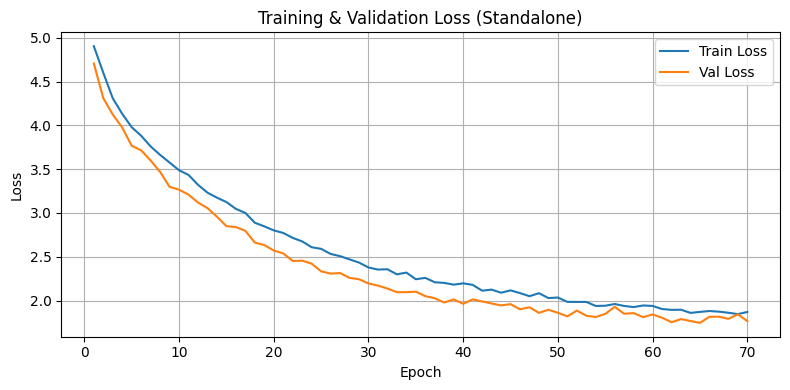

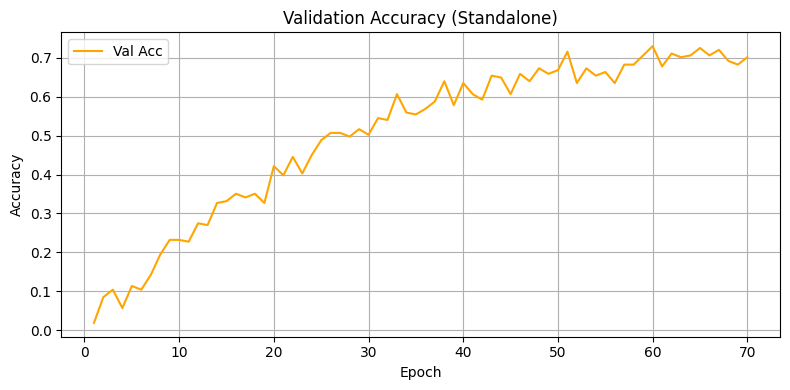

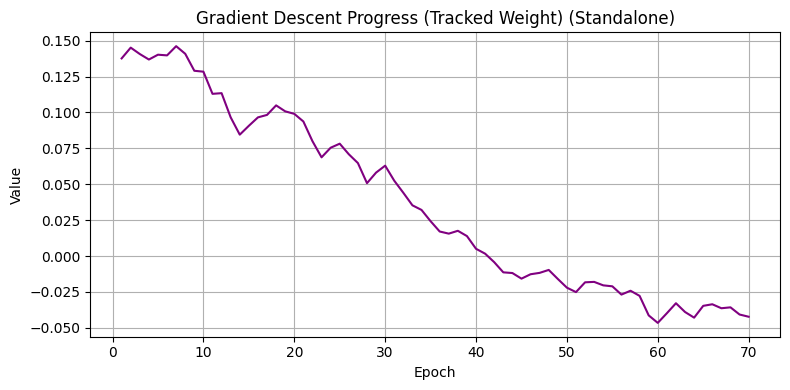

In [43]:
model_standalone, hist = train_localizer_full_with_val(batch_size=cfg.batch_size)
train_losses, val_losses, val_accuracies, tracked_weights = hist
plot_curves(train_losses, val_losses, val_accuracies, tracked_weights, fold_title='(Standalone)')

### Standalone Inference & Evaluation (All Sequences)


\n=== Summary Metrics ===\n
   Metric  Score
 Accuracy 0.8551
Precision 0.8976
   Recall 0.8551
 F1 Score 0.8621
\n=== Classification Report (per class) ===\n
              precision    recall  f1-score   support

           0     0.7500    1.0000    0.8571         6
           1     0.7500    0.7500    0.7500         4
           2     1.0000    0.6429    0.7826        14
           3     0.5000    1.0000    0.6667         4
           4     0.6667    1.0000    0.8000         4
           5     0.5000    0.2500    0.3333         4
           6     0.8667    0.7222    0.7879        18
           7     0.8000    0.9524    0.8696        21
           8     1.0000    0.8947    0.9444        19
           9     0.8000    0.8889    0.8421        18
          10     0.9048    1.0000    0.9500        19
          11     1.0000    0.8889    0.9412        27
          12     0.9091    0.7407    0.8163        27
          13     0.8276    0.9231    0.8727        26
          14     0.8889    1.0

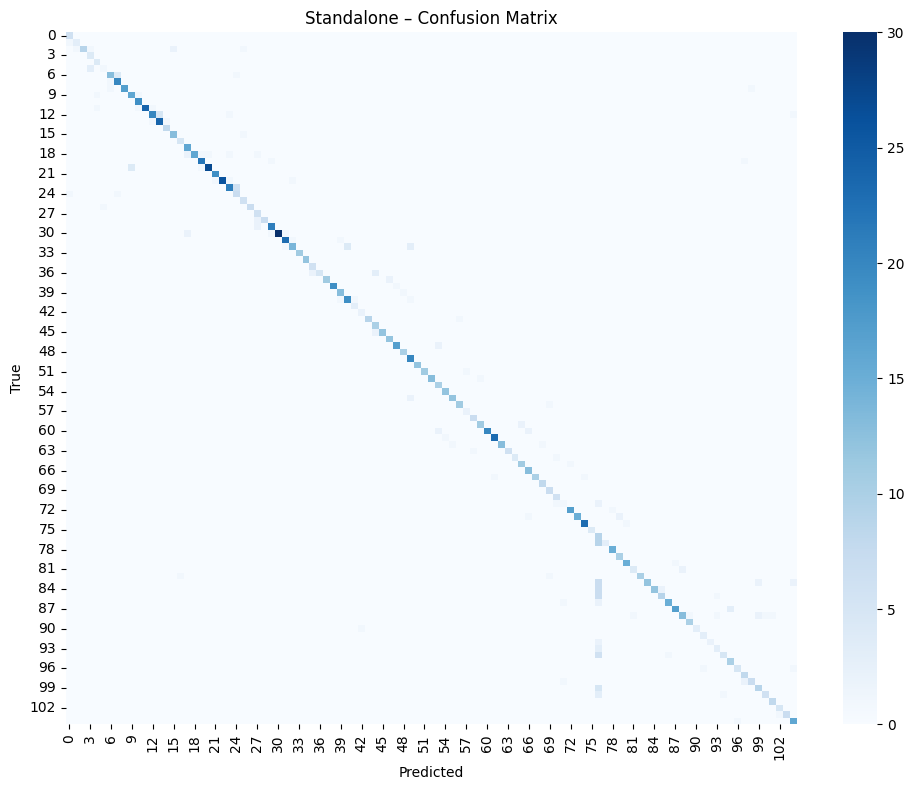

In [44]:
# Inference on all sequences (for evaluation demo)
device = cfg.device
X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
with torch.no_grad():
    logits = model_standalone(X_tensor)
    preds_standalone = logits.argmax(1).cpu().numpy()

summarize_metrics(y_seq, preds_standalone, idx_to_coords)
plot_conf_mat(y_seq, preds_standalone, title='Standalone – Confusion Matrix')

## Classical Baselines on AE-Encoded Features


In [31]:
baseline_results = run_baselines_on_encoded(X_seq, y_seq, cfg.input_dim, cfg.latent_dim, cfg.sequence_length)


KNN Accuracy: 0.2456               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           6       0.09      0.25      0.13         4
           7       0.17      0.25      0.20         4
           8       0.14      0.25      0.18         4
           9       0.33      0.50      0.40         4
          10       0.75      0.75      0.75         4
          11       1.00      0.60      0.75         5
          12       1.00      0.20      0.33         5
          13       0.57      0.80      0.67         5
          14       1.00      0.50      0.67         2
          15       0.33      0.33      0.33         3
          16       1.00      1.00      1.00         1
      

## K-Fold Ensemble Training & Soft-Voting Inference


Using n_splits=3 (min per class=2)
Training Fold 1
Epoch 01 | Train 4.9145 | Val 4.9206 | ValAcc 0.0107 | mF1 0.0009
Epoch 02 | Train 4.8298 | Val 4.6949 | ValAcc 0.0385 | mF1 0.0045
Epoch 03 | Train 4.5781 | Val 4.4038 | ValAcc 0.0385 | mF1 0.0118
Epoch 04 | Train 4.3138 | Val 4.1814 | ValAcc 0.0728 | mF1 0.0215
Epoch 05 | Train 4.1544 | Val 4.0182 | ValAcc 0.0899 | mF1 0.0507
Epoch 06 | Train 4.0097 | Val 3.9001 | ValAcc 0.1135 | mF1 0.0585
Epoch 07 | Train 3.9415 | Val 3.8354 | ValAcc 0.1092 | mF1 0.0642
Epoch 08 | Train 3.8385 | Val 3.6920 | ValAcc 0.1585 | mF1 0.1156
Epoch 09 | Train 3.6990 | Val 3.6329 | ValAcc 0.1520 | mF1 0.0865
Epoch 10 | Train 3.6237 | Val 3.5223 | ValAcc 0.2077 | mF1 0.1835
Epoch 11 | Train 3.5681 | Val 3.4453 | ValAcc 0.1949 | mF1 0.1765
Epoch 12 | Train 3.4485 | Val 3.4165 | ValAcc 0.2099 | mF1 0.1754
Epoch 13 | Train 3.4054 | Val 3.3533 | ValAcc 0.2484 | mF1 0.2314
Epoch 14 | Train 3.3246 | Val 3.2338 | ValAcc 0.2719 | mF1 0.2390
Epoch 15 | Train 3.2340 |

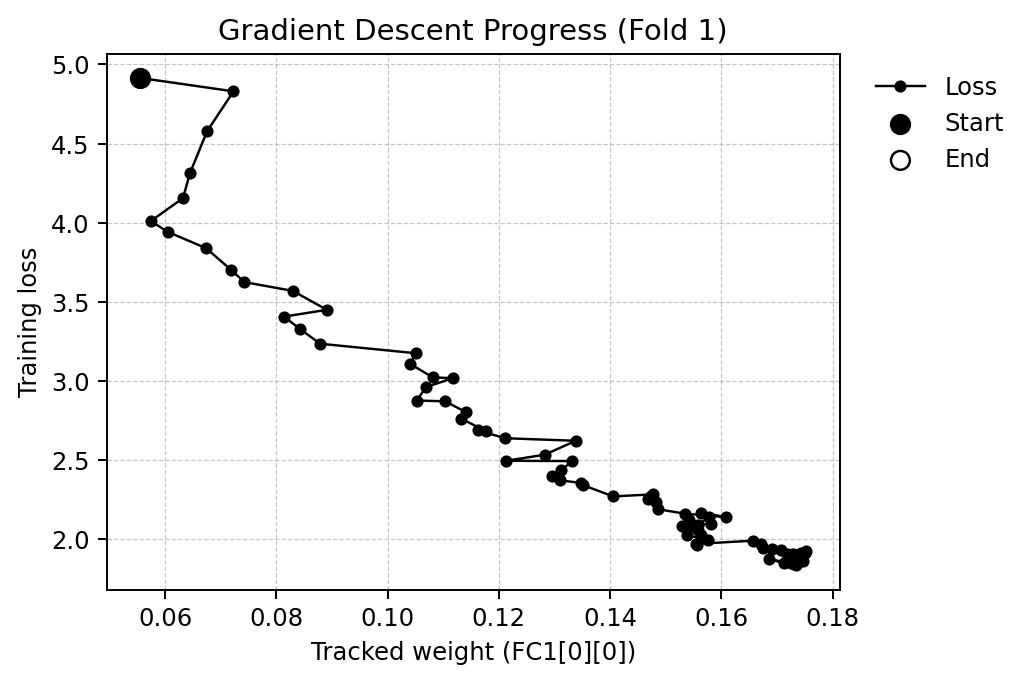

Training Fold 2
Epoch 01 | Train 4.9206 | Val 4.9345 | ValAcc 0.0171 | mF1 0.0042
Epoch 02 | Train 4.8400 | Val 4.7380 | ValAcc 0.0193 | mF1 0.0053
Epoch 03 | Train 4.5891 | Val 4.4232 | ValAcc 0.0685 | mF1 0.0204
Epoch 04 | Train 4.3112 | Val 4.1783 | ValAcc 0.0557 | mF1 0.0231
Epoch 05 | Train 4.0785 | Val 4.0112 | ValAcc 0.1092 | mF1 0.0492
Epoch 06 | Train 3.9173 | Val 3.8711 | ValAcc 0.1263 | mF1 0.0780
Epoch 07 | Train 3.7894 | Val 3.7859 | ValAcc 0.1713 | mF1 0.1110
Epoch 08 | Train 3.6673 | Val 3.7239 | ValAcc 0.1585 | mF1 0.1160
Epoch 09 | Train 3.6799 | Val 3.6172 | ValAcc 0.1906 | mF1 0.1445
Epoch 10 | Train 3.5305 | Val 3.5566 | ValAcc 0.1970 | mF1 0.1507
Epoch 11 | Train 3.4672 | Val 3.4958 | ValAcc 0.2184 | mF1 0.1739
Epoch 12 | Train 3.4051 | Val 3.3960 | ValAcc 0.2248 | mF1 0.1972
Epoch 13 | Train 3.2771 | Val 3.3886 | ValAcc 0.2334 | mF1 0.1949
Epoch 14 | Train 3.2651 | Val 3.2937 | ValAcc 0.2655 | mF1 0.2219
Epoch 15 | Train 3.1623 | Val 3.2396 | ValAcc 0.2655 | mF1 0

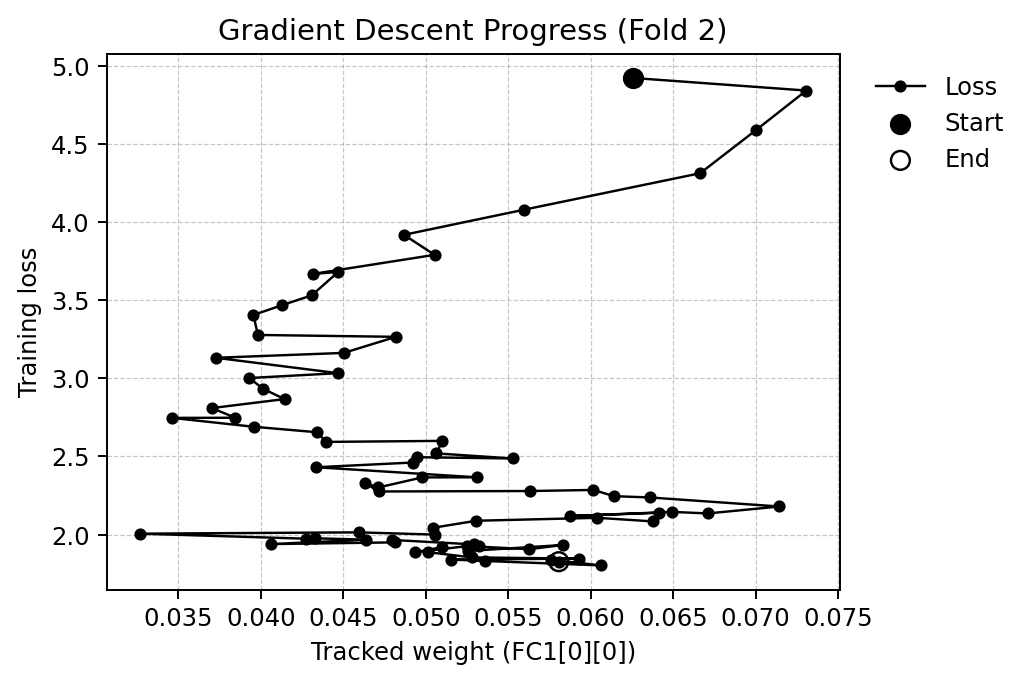

Training Fold 3
Epoch 01 | Train 4.9050 | Val 4.9092 | ValAcc 0.0214 | mF1 0.0041
Epoch 02 | Train 4.7912 | Val 4.6792 | ValAcc 0.0428 | mF1 0.0071
Epoch 03 | Train 4.5730 | Val 4.3882 | ValAcc 0.0557 | mF1 0.0109
Epoch 04 | Train 4.3287 | Val 4.2199 | ValAcc 0.0835 | mF1 0.0254
Epoch 05 | Train 4.1457 | Val 4.0324 | ValAcc 0.1071 | mF1 0.0574
Epoch 06 | Train 4.0071 | Val 3.9286 | ValAcc 0.1006 | mF1 0.0579
Epoch 07 | Train 3.8943 | Val 3.7730 | ValAcc 0.1478 | mF1 0.0855
Epoch 08 | Train 3.7940 | Val 3.6835 | ValAcc 0.1499 | mF1 0.1067
Epoch 09 | Train 3.6912 | Val 3.5897 | ValAcc 0.2056 | mF1 0.1504
Epoch 10 | Train 3.5909 | Val 3.5587 | ValAcc 0.1756 | mF1 0.1278
Epoch 11 | Train 3.4880 | Val 3.4426 | ValAcc 0.2120 | mF1 0.1834
Epoch 12 | Train 3.4525 | Val 3.4060 | ValAcc 0.2206 | mF1 0.1875
Epoch 13 | Train 3.3762 | Val 3.3311 | ValAcc 0.2505 | mF1 0.2217
Epoch 14 | Train 3.2671 | Val 3.2671 | ValAcc 0.2548 | mF1 0.2357
Epoch 15 | Train 3.2093 | Val 3.1937 | ValAcc 0.2741 | mF1 0

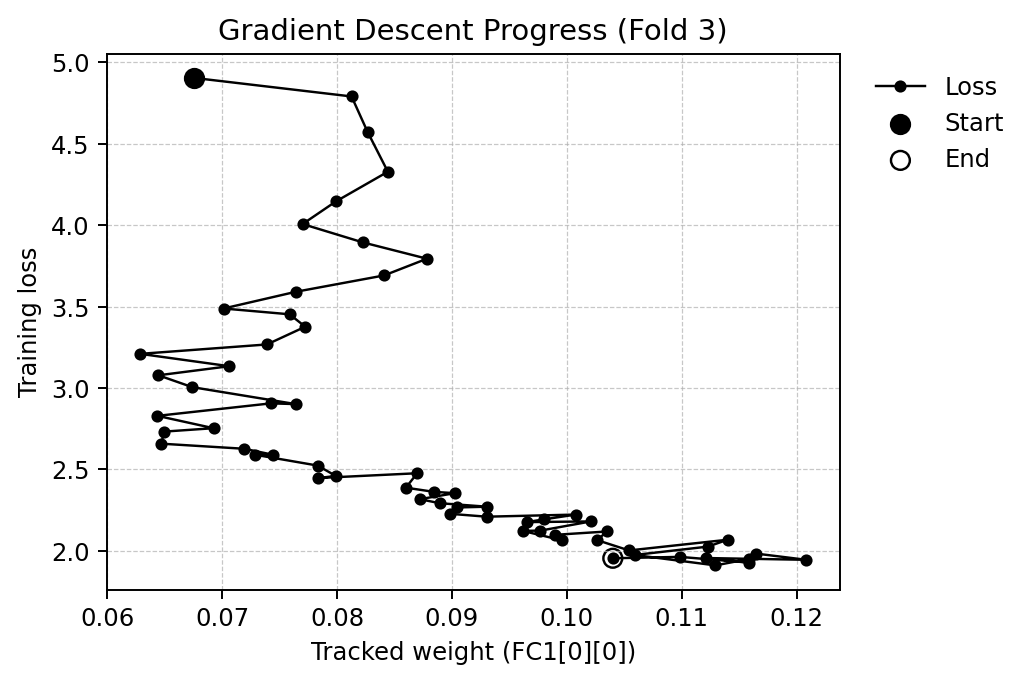

In [41]:
# --- K-Fold Ensemble (adjust splits based on class counts) ---
_, counts = np.unique(y_seq, return_counts=True)
n_splits = int(max(3, min(5, counts.min())))
print(f'Using n_splits={n_splits} (min per class={counts.min()})')

models, all_train, all_val, all_acc, all_w = train_localizer_kfold_ensemble(X_seq, y_seq, batch_size=cfg.batch_size, n_splits=n_splits)

# Ensemble predict (soft voting over logits)
test_loader = DataLoader(TensorDataset(torch.tensor(X_seq, dtype=torch.float32),
                                       torch.tensor(y_seq, dtype=torch.long)),
                         batch_size=32, shuffle=False)
final_preds = ensemble_predict(models, test_loader, cfg.device)

### Per-Fold Training Curves (Loss / Val Loss / Val Acc / Tracked Weight)


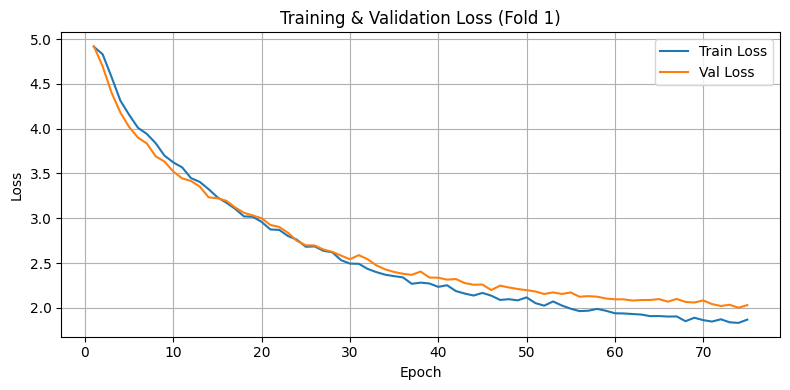

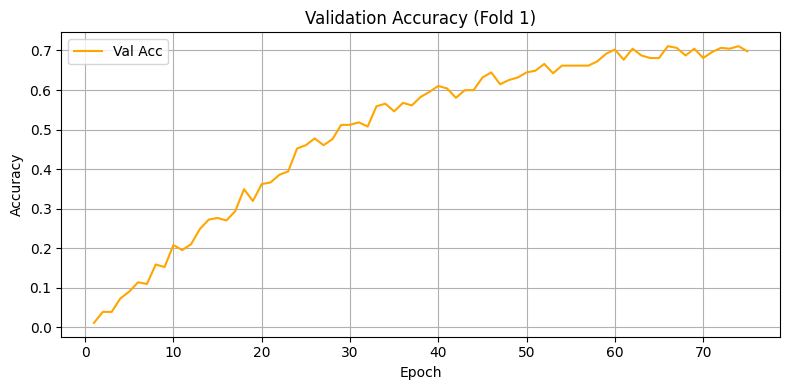

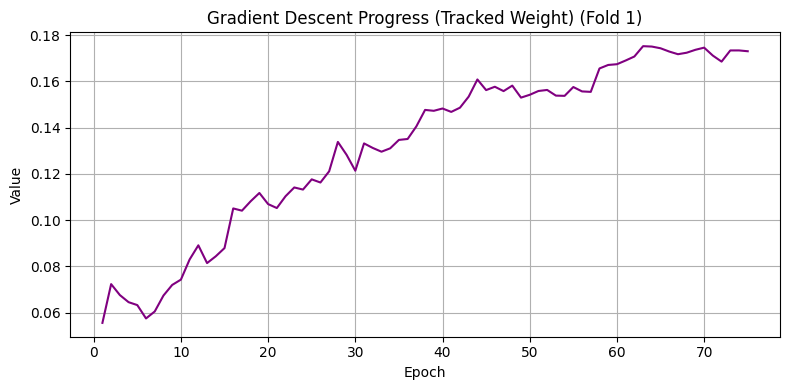

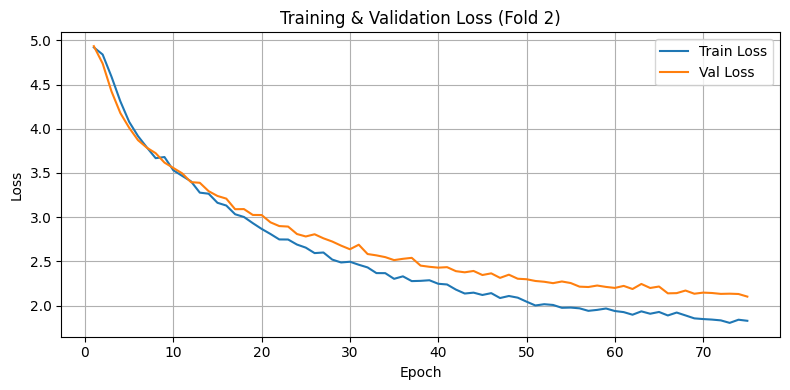

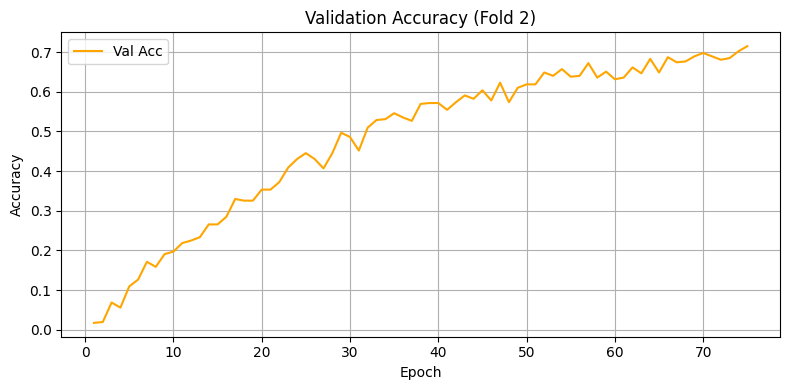

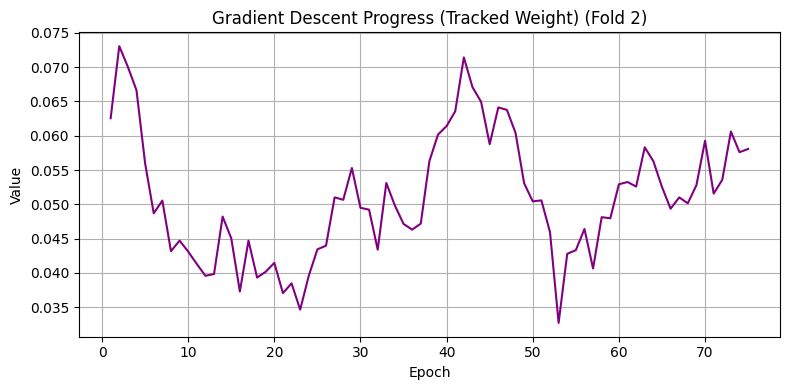

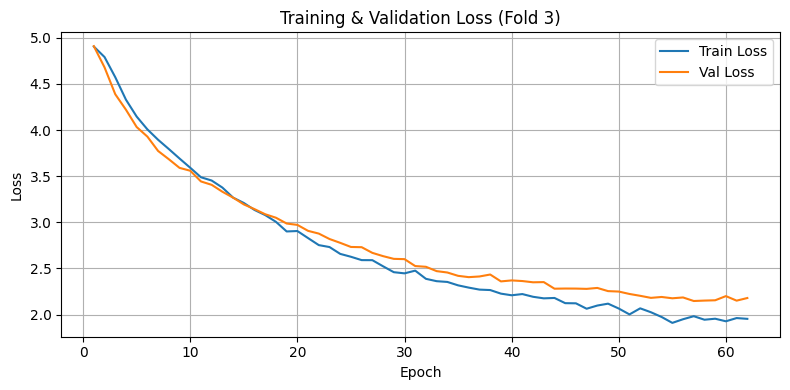

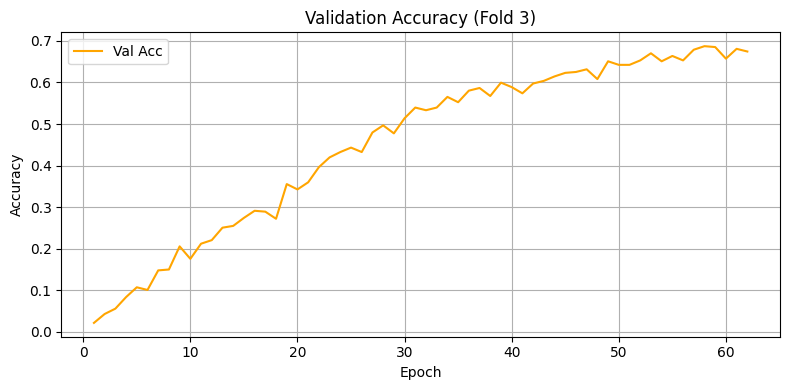

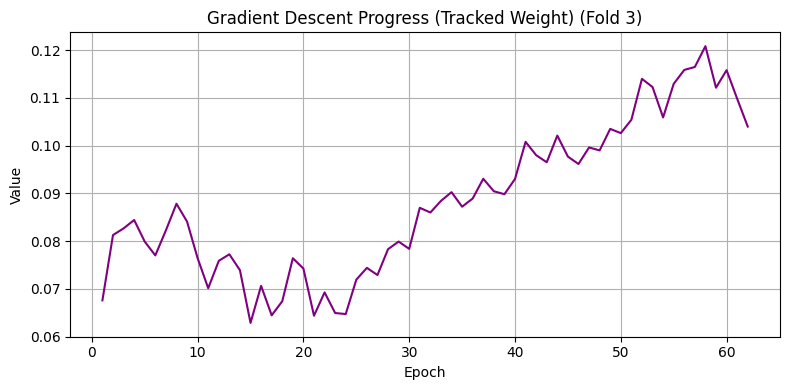

In [39]:
# Per-fold plots
for i in range(len(all_train)):
    plot_curves(all_train[i], all_val[i], all_acc[i], all_w[i], fold_title=f'(Fold {i+1})')

## Ensemble: Summary Metrics & Confusion Matrix

 K-Fold Ensemble 
\n=== Summary Metrics ===\n
   Metric  Score
 Accuracy 0.8772
Precision 0.9160
   Recall 0.8772
 F1 Score 0.8849
\n=== Classification Report (per class) ===\n
              precision    recall  f1-score   support

           0     0.7500    1.0000    0.8571         6
           1     0.6000    0.7500    0.6667         4
           2     1.0000    0.6429    0.7826        14
           3     0.6667    0.5000    0.5714         4
           4     0.6667    1.0000    0.8000         4
           5     0.6000    0.7500    0.6667         4
           6     1.0000    0.8889    0.9412        18
           7     0.8750    1.0000    0.9333        21
           8     0.8947    0.8947    0.8947        19
           9     0.8421    0.8889    0.8649        18
          10     0.9048    1.0000    0.9500        19
          11     0.8889    0.8889    0.8889        27
          12     0.8696    0.7407    0.8000        27
          13     0.9545    0.8077    0.8750        26
          14

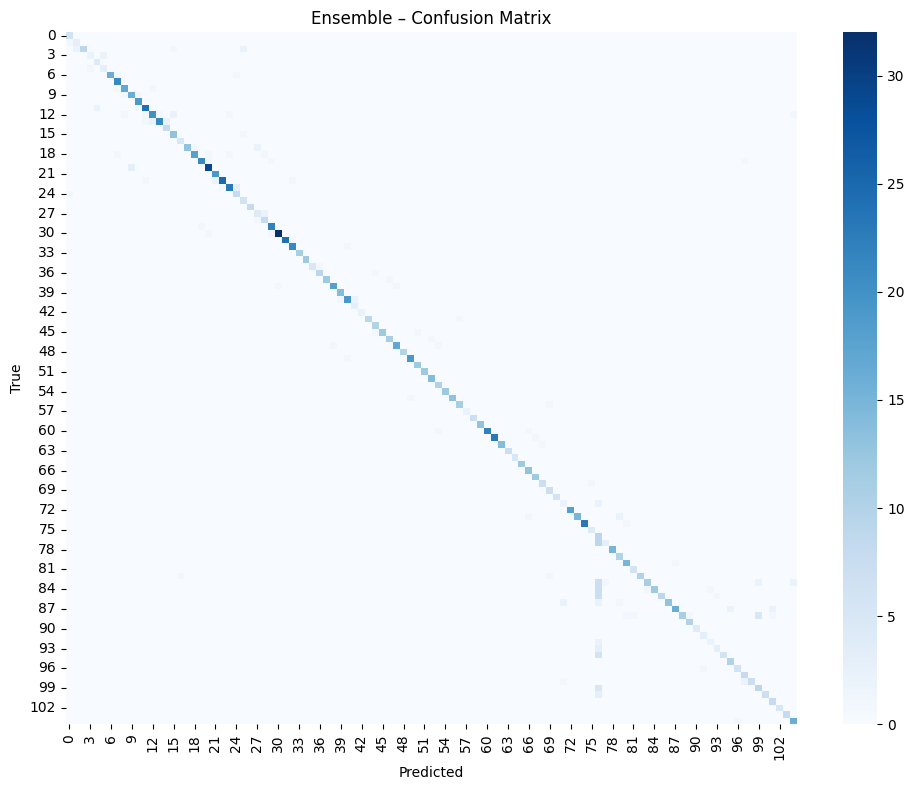

In [40]:
# Summary metrics
print(" K-Fold Ensemble ")
summarize_metrics(y_seq, final_preds, idx_to_coords)
plot_conf_mat(y_seq, final_preds, title='Ensemble – Confusion Matrix')

## t-SNE Visualization of AE-Encoded Sequences


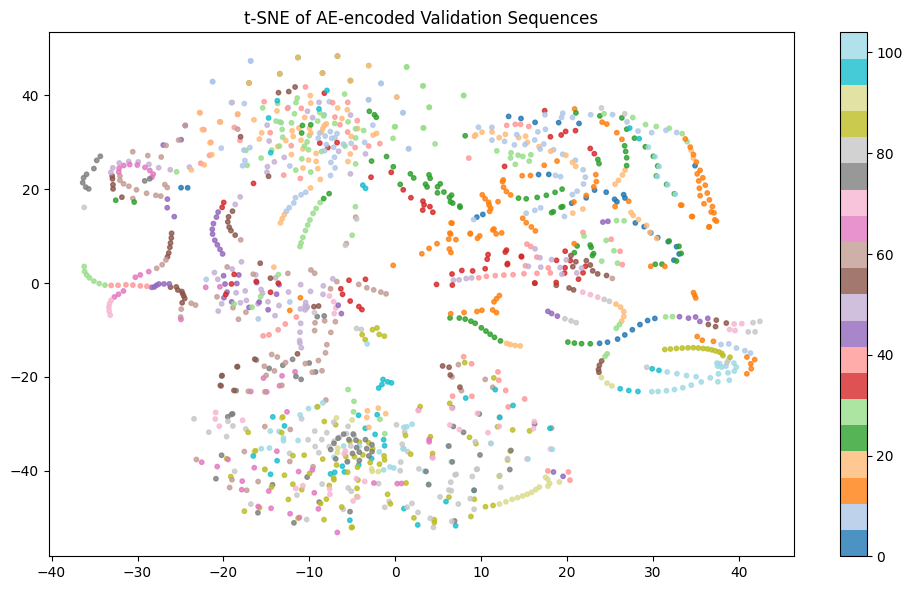

In [15]:
# --- t-SNE on encoded features (from AE) ---
ae = RSSIAutoencoder(cfg.input_dim, cfg.latent_dim).to(cfg.device)
ae_path = os.path.join('models','autoencoder_pretrained.pth')
if os.path.exists(ae_path):
    ae.load_state_dict(torch.load(ae_path, map_location=cfg.device))
ae.eval()
with torch.no_grad():
    Xt = torch.tensor(X_seq, dtype=torch.float32).to(cfg.device).permute(0,2,1)
    X_encoded = ae.encoder(Xt).cpu().numpy().reshape(X_seq.shape[0], -1)

plot_tsne(X_encoded, y_seq, title='t-SNE of AE-encoded Validation Sequences')

## Animated Floorplan Visualization (Actual vs Predicted Paths)

In [16]:
# --- Animated floorplan visualization (adjust paths & coords) ---
# Prepare coords from ensemble (or standalone) predictions
pred_coords = [idx_to_coords[int(idx)] for idx in final_preds]
true_coords = [idx_to_coords[int(idx)] for idx in y_seq]
timestamps = pd.to_datetime(data['date'].values[cfg.sequence_length-1: cfg.sequence_length-1+len(y_seq)]) \
             if 'date' in data.columns else pd.date_range('2024-01-01', periods=len(y_seq), freq='S')


img1 = 'iBeacon_Layout.jpg'  # change if needed

fig = animate_paths(true_coords, pred_coords, timestamps, image_path=img1,
                    xrange=(0,25), yrange=(0,20),
                    title='Indoor Position Tracking: Actual vs Predicted Paths')
fig.show()

## Animated Floorplan Visualization (Actual vs Predicted Paths): Different Layout

In [17]:
# --- Animated floorplan visualization (adjust paths & coords) ---
# Prepare coords from ensemble (or standalone) predictions
pred_coords = [idx_to_coords[int(idx)] for idx in final_preds]
true_coords = [idx_to_coords[int(idx)] for idx in y_seq]
timestamps = pd.to_datetime(data['date'].values[cfg.sequence_length-1: cfg.sequence_length-1+len(y_seq)]) \
             if 'date' in data.columns else pd.date_range('2024-01-01', periods=len(y_seq), freq='S')

# Optional beacons
BEACON_COORDS = {
    "b3001": (7, 13), "b3002": (18, 14), "b3003": (7, 3),  "b3004": (9, 8),
    "b3005": (4, 9),  "b3006": (16, 9), "b3007": (12, 14), "b3008": (21, 8),
    "b3009": (3, 6),  "b3010": (11, 4), "b3011": (17, 5),  "b3012": (14, 16), "b3013": (23, 4)
}
BEACON_ROOM_MAP = {
    "b3001": "Bedroom", "b3002": "Master Bedroom", "b3003": "Patio", "b3004": "Common Area",
    "b3005": "Left Balcony", "b3006": "Dining Hall", "b3007": "Rest Room", "b3008": "Right Balcony",
    "b3009": "Store Room", "b3010": "Entrance", "b3011": "Kitchen", "b3012": "Laundry", "b3013": "Dish Washing"
}
img1 = '3d House.jpg'  # change if needed

fig = animate_paths(true_coords, pred_coords, timestamps, image_path=img1,
                    xrange=(0,25), yrange=(0,20), beacon_coords=BEACON_COORDS, beacon_names=BEACON_ROOM_MAP,
                    title='Indoor Position Tracking: Actual vs Predicted Paths')
fig.show()

## CDF of Localization Error

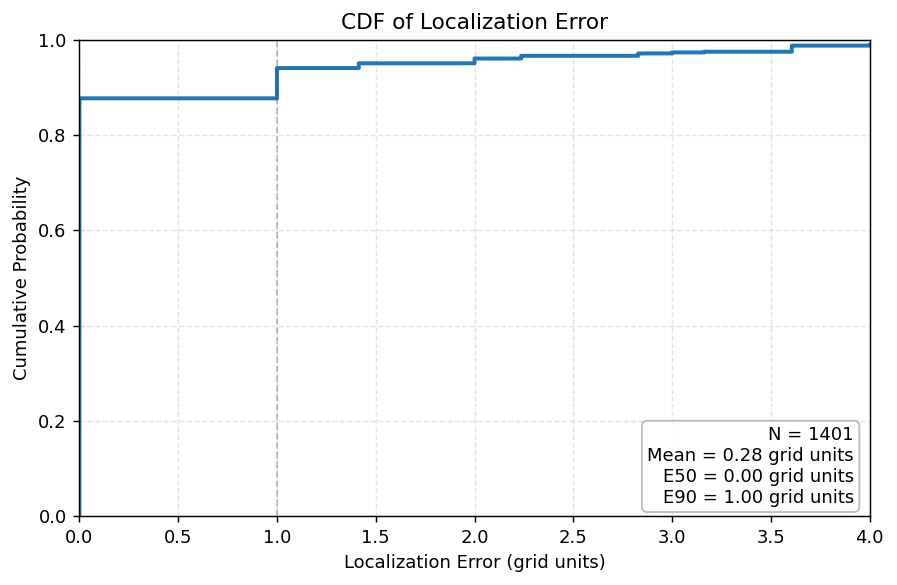

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def plot_error_cdf_clean(errors,
                         unit="grid units",
                         grid_to_m=None,          # e.g. 0.6 → plot in meters
                         show_quantiles=(0.50, 0.90),
                         thresholds=(),           # e.g. (1, 2) if you want a couple of callouts
                         x_clip=0.99,             # clip x-axis at 99th pct to avoid long-tail squeeze
                         title="CDF of Localization Error"):
    """
    Minimal, uncluttered CDF:
      • step-ECDF (no markers)
      • only E50/E90 dashed lines (configurable)
      • tiny summary box (N, mean, E50, E90)
      • optional top axis in meters via grid_to_m
    """
    e = np.asarray(errors, float)
    if grid_to_m is not None:
        e = e * float(grid_to_m)
        unit = "m"

    e = e[np.isfinite(e)]
    if e.size == 0:
        raise ValueError("No finite errors provided.")
    e.sort()
    cdf = np.arange(1, len(e) + 1) / len(e)

    # axis range (keeps the curve readable if a few huge errors exist)
    xmax = float(np.quantile(e, x_clip))

    fig, ax = plt.subplots(figsize=(7, 4.6), dpi=130)
    ax.step(e, cdf, where="post", linewidth=2.2)     # clean ECDF (no scatter)
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, 1)
    ax.set_xlabel(f"Localization Error ({unit})")
    ax.set_ylabel("Cumulative Probability")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.35)

    # subtle quantile lines (default: E50 & E90)
    qvals = {}
    for q in show_quantiles:
        xq = float(np.quantile(e, q))
        qvals[f"E{int(q*100)}"] = xq
        ax.axvline(xq, linestyle="--", color="0.3", alpha=0.35, linewidth=1)

    # optional simple threshold callouts (kept minimal; prints to console instead of plotting text)
    for thr in thresholds:
        pct = (e <= thr).mean() * 100.0
        print(f"{pct:.1f}% ≤ {thr} {unit}")

    # compact summary box (no big labels on the curve)
    mean = e.mean()
    e50 = qvals.get("E50", np.quantile(e, 0.50))
    e90 = qvals.get("E90", np.quantile(e, 0.90))
    txt = f"N = {len(e)}\nMean = {mean:.2f} {unit}\nE50 = {e50:.2f} {unit}\nE90 = {e90:.2f} {unit}"
    ax.text(0.98, 0.02, txt, transform=ax.transAxes, ha="right", va="bottom",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.9, ec="0.7"))

    # optional top axis in meters
    if (grid_to_m is not None):
        secax = ax.secondary_xaxis('top',
                                   functions=(lambda u: u, lambda m: m))  # already in meters
        secax.set_xlabel("Localization Error (m)")

    plt.tight_layout()
    return fig
fig = plot_error_cdf_clean(errors, unit="grid units", show_quantiles=(0.50, 0.90))
plt.show()

In [70]:
# === Ultra-clean CDF of localization error ===================================
import numpy as np
import plotly.graph_objects as go

def cdf_ultraclean(errors, unit="grid units", scale_m=None,
                   x_clip=0.99, y_guides=(0.90,), title="CDF of Localization Error"):
    """
    errors : 1D array of per-sample localization errors (in grid units)
    scale_m: multiply errors by this to plot in meters (e.g., 0.6)
    x_clip : show up to this percentile on x-axis to avoid long-tail squeeze
    y_guides: optional subtle horizontal guides, e.g., (0.90,) for 90%
    """
    e = np.asarray(errors, float)
    if scale_m is not None:
        e = e * float(scale_m)
        unit = "m"

    e = e[np.isfinite(e)]
    e.sort()
    cdf = np.arange(1, len(e)+1) / len(e)

    # axis clip keeps the curve readable
    xmax = float(np.quantile(e, x_clip))

    fig = go.Figure(go.Scatter(
        x=e, y=cdf, mode="lines",
        line=dict(width=3),
        line_shape="hv",  # proper ECDF look
        hovertemplate=f"Error: %{{x:.2f}} {unit}<br>CDF: %{{y:.1%}}<extra></extra>"
    ))

    # subtle horizontal guides (e.g., 90%)
    for yg in y_guides:
        fig.add_hline(y=yg, line_dash="dot", line_color="rgba(0,0,0,0.18)", line_width=1)

    # compact summary only (no inline markers)
    mean = e.mean()
    p50, p90 = np.quantile(e, [0.50, 0.90])
    txt = f"N = {len(e)}<br>Mean = {mean:.2f} {unit}<br>E50 = {p50:.2f} {unit}<br>E90 = {p90:.2f} {unit}"
    fig.add_annotation(
        xref="paper", yref="paper", x=0.98, y=0.02, showarrow=False,
        text=txt, align="right",
        bordercolor="rgba(0,0,0,0.15)", borderwidth=1,
        bgcolor="rgba(255,255,255,0.9)", font=dict(size=12)
    )

    fig.update_layout(
        title=title,
        template="simple_white",
        xaxis_title=f"Localization Error ({unit})",
        yaxis_title="Cumulative Probability",
        xaxis=dict(range=[0, xmax]),
        yaxis=dict(range=[0, 1], tickvals=[0, 0.5, 1], tickformat=".0%"),
        margin=dict(l=60, r=20, t=60, b=50),
        showlegend=False,
    )
    return fig

# --- minimal usage ------------------------------------------------------------
# 1) if you already have coords -> errors:
true_arr = np.array(true_coords); pred_arr = np.array(pred_coords)
errors = np.linalg.norm(true_arr - pred_arr, axis=1)

# 2) plot (grid units)
fig = cdf_ultraclean(errors, unit="grid units", x_clip=0.99)
fig.show()

# 3) same plot in meters (e.g., each grid = 0.6 m), with a 90% guide only
# fig = cdf_ultraclean(errors, scale_m=0.6, x_clip=0.99, y_guides=(0.90,))
# fig.show()


## Localization Error Heatmap

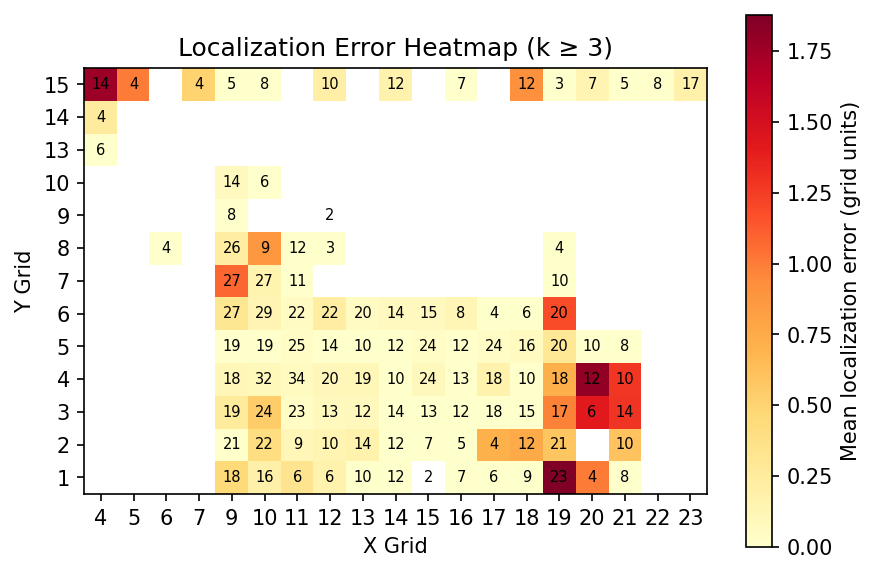

In [24]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---------- Ensure eval_df exists ----------
if 'eval_df' not in globals():
    if 'true_coords' in globals() and 'pred_coords' in globals():
        eval_df = pd.DataFrame({
            'true_x': [x for x, _ in true_coords],
            'true_y': [y for _, y in true_coords],
            'pred_x': [x for x, _ in pred_coords],
            'pred_y': [y for _, y in pred_coords],
        })
    elif all(k in globals() for k in ('y_seq','final_preds','idx_to_coords')):
        true_coords = [idx_to_coords[int(i)] for i in y_seq]
        pred_coords = [idx_to_coords[int(i)] for i in final_preds]
        eval_df = pd.DataFrame({
            'true_x': [x for x, _ in true_coords],
            'true_y': [y for _, y in true_coords],
            'pred_x': [x for x, _ in pred_coords],
            'pred_y': [y for _, y in pred_coords],
        })
    else:
        raise RuntimeError("Need (true_coords & pred_coords) OR (y_seq, final_preds, idx_to_coords).")

# ---------- Per-sample absolute error (in grid units) ----------
if 'abs_err' not in eval_df:
    eval_df['abs_err'] = np.hypot(
        eval_df['true_x'] - eval_df['pred_x'],
        eval_df['true_y'] - eval_df['pred_y']
    )

# ---------- Aggregate to heatmap (mean error per true grid cell) ----------
grp   = eval_df.groupby(['true_y','true_x'])
heat  = grp['abs_err'].mean().unstack()                 # mean error
count = grp.size().unstack().reindex_like(heat).fillna(0).astype(int)  # sample count per cell

# Optional: convert to meters if your cell size is known
# CELL_SIZE_M = 1.0
# heat = heat * CELL_SIZE_M

# ---------- Mask cells with too few samples ----------
k = 3  # minimum samples per cell to display
heat_masked = heat.where(count >= k)

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
im = ax.imshow(heat_masked, origin='lower', cmap='YlOrRd')
fig.colorbar(im, ax=ax, label='Mean localization error (grid units)')
ax.set_title(f'Localization Error Heatmap (k ≥ {k})')
ax.set_xlabel('X Grid'); ax.set_ylabel('Y Grid')

# Use actual grid indices as tick labels
ax.set_xticks(range(heat_masked.shape[1])); ax.set_xticklabels(heat_masked.columns)
ax.set_yticks(range(heat_masked.shape[0])); ax.set_yticklabels(heat_masked.index)

# Overlay sample counts (small text) so you know coverage
for iy in range(count.shape[0]):
    for ix in range(count.shape[1]):
        n = count.iloc[iy, ix]
        if n > 0:
            ax.text(ix, iy, str(n), ha='center', va='center', fontsize=7, color='black')

plt.tight_layout()
plt.show()


## 3D View: LiDAR Floor + Paths + Beacons

In [32]:
import numpy as np
import plotly.graph_objects as go

# ---- inputs expected from your notebook ----
# true_coords, pred_coords: list[(x,y)] in GRID UNITS
# BEACON_COORDS: dict beacon_id -> (x,y, [label])
# layout size (in grid cells) for the floor plane:
LAYOUT_W, LAYOUT_H = 25, 20

# ---- grid → meters (adjust) ----
CELL_SIZE_M = 1.0   # <= set your grid-cell size in meters
Z0 = 0.0            # floor elevation (m). If you have per-sample z, replace with that array.

x_true = np.array([x for x,_ in true_coords]) * CELL_SIZE_M
y_true = np.array([y for _,y in true_coords]) * CELL_SIZE_M
z_true = np.full_like(x_true, Z0)

x_pred = np.array([x for x,_ in pred_coords]) * CELL_SIZE_M
y_pred = np.array([y for _,y in pred_coords]) * CELL_SIZE_M
z_pred = np.full_like(x_pred, Z0)

fig = go.Figure()

# Actual & Predicted paths
fig.add_trace(go.Scatter3d(x=x_true, y=y_true, z=z_true,
                           mode='lines+markers', name='Actual',
                           marker=dict(size=2, symbol='circle')))
fig.add_trace(go.Scatter3d(x=x_pred, y=y_pred, z=z_pred,
                           mode='lines+markers', name='Prediction',
                           marker=dict(size=3, symbol='diamond-open')))

# Beacons (assume mounted at ~2 m height)'Prediction':'diamond-open','Actual':'circle'
if 'BEACON_COORDS' in globals():
    bx, by, bz, labels = [], [], [], []
    for k, tup in BEACON_COORDS.items():
        x, y = tup[0], tup[1]
        label = tup[2] if len(tup) > 2 else k
        bx.append(x * CELL_SIZE_M); by.append(y * CELL_SIZE_M); bz.append(2.0)
        labels.append(label)
    fig.add_trace(go.Scatter3d(x=bx, y=by, z=bz, mode='markers+text',
                               name='Beacons', text=labels,
                               textposition='top center', marker=dict(size=5)))

# Optional: draw a translucent floor plane
Xf, Yf = np.meshgrid([0, LAYOUT_W*CELL_SIZE_M], [0, LAYOUT_H*CELL_SIZE_M])
Zf = np.full_like(Xf, Z0)
fig.add_trace(go.Surface(x=Xf, y=Yf, z=Zf, showscale=False, opacity=0.25, name='Floor'))

fig.update_layout(
    scene=dict(xaxis_title='X (m)', yaxis_title='Y (m)', zaxis_title='Z (m)',
               aspectmode='data'),
    title='3D View: LiDAR Floor + Paths + Beacons'
)
fig.show()
